In [1]:
from datetime import datetime
from metloom.pointdata import SnotelPointData
import pandas as pd
import cartopy
import geoviews as gv
import geopandas as gpd
import holoviews as hv
import xarray as xr
from metsim import MetSim
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [2]:
snotel_point = SnotelPointData("728:WA:SNTL", "MyStation")
df = snotel_point.get_hourly_data(
    datetime(2020, 7, 2), datetime(2021, 9, 30),
    [snotel_point.ALLOWED_VARIABLES.PRECIPITATIONACCUM, snotel_point.ALLOWED_VARIABLES.TEMP]
)

# Clean up the dataframe
df.reset_index(inplace=True)
df.set_index('datetime', inplace=True)
print(df['geometry'][0])
df.drop(columns=['site', 'ACCUMULATED PRECIPITATION_units', 'geometry', 'AIR TEMP_units', 'datasource'], inplace=True)

# Rename columns
replace = {'ACCUMULATED PRECIPITATION':'accppt','AIR TEMP':'airtemp'}
df.rename(columns=replace, inplace=True)

POINT Z (-119.8383 48.65518 4460)


/Users/clintonalden/miniconda3/envs/env1/lib/python3.12/site-packages/geopandas/geoseries.py:641: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)


In [3]:
# Covert air temperature to celsius
df['airtemp'] = (df['airtemp'] - 32) * 5.0/9.0

# Convert precipitation to mm
df['accppt'] = df['accppt'] * 25.4

# Convert from geodataframe to dataframe
df = pd.DataFrame(df)


In [4]:
from pytz import UTC
# Interpolate the missing values
df.interpolate(inplace=True)

# Seperate the data into two dataframes, before and after October 1
spinstart = pd.to_datetime('2020-07-03').tz_localize('UTC')
spinend = pd.to_datetime('2020-09-30').tz_localize('UTC')
spinup = df.loc[spinstart:spinend]
data = df.loc[datetime(2020, 10, 1).replace(tzinfo=UTC):]

# Copy the dataframe a2 to a2_copy
data_copy = data.copy()

# Create a mask to identify rows where the index is less than or equal to October 2, 2023
mask = data_copy.index <= datetime(2020, 10, 2).replace(tzinfo=UTC)

# Set the 'precip_accum' column to 0 for rows that satisfy the mask condition
data_copy.loc[mask, 'accppt'] = 0

# Update the value of a2 to the modified copy
data = data_copy

# Calculate the difference between the maximum value of 'precip_accum' and the previous value
spinup['pptrate'] = spinup['accppt'].cummax().diff()
data['pptrate'] = data['accppt'].cummax().diff()

# Drop accppt column
spinup.drop(columns=['accppt'], inplace=True)
data.drop(columns=['accppt'], inplace=True)

/var/folders/db/7c91t8d577n1zsyhth1xc7840000gn/T/ipykernel_49965/3274282802.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spinup['pptrate'] = spinup['accppt'].cummax().diff()
/var/folders/db/7c91t8d577n1zsyhth1xc7840000gn/T/ipykernel_49965/3274282802.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spinup.drop(columns=['accppt'], inplace=True)


<Axes: xlabel='datetime'>

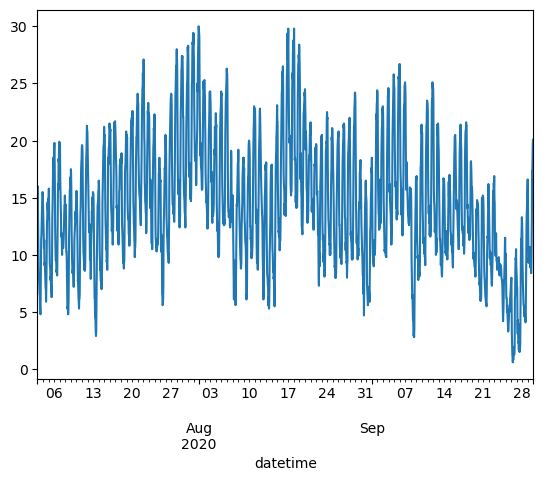

In [5]:
spinup.airtemp.plot()

## Generate SW from MetSim

In [6]:
# Create empty dataset
dates = pd.date_range('10/01/2020', '09/30/2021')
shape = (len(dates), 1, 1, )
dims = ('time', 'lat', 'lon', )

# We are running only one site, at these coordinates
lats = [48.66]
lons = [-119.84]
elev = 1359.4 # meters
coords = {'time': dates, 'lat': lats, 'lon': lons}

# Create the initial met data input data structure
met_data = xr.Dataset(coords=coords)

In [7]:
for varname in ['prec', 't_min', 't_max']:
    met_data[varname] = xr.DataArray(data=np.full(shape, np.nan),
                                     coords=coords, dims=dims,
                                     name=varname)

In [12]:
# Resample the data to daily frequency and calculate the maximum and minimum temperatures
tmax_vals = data['airtemp'].resample('D').max()
tmin_vals = data['airtemp'].resample('D').min()

# Calculate the daily precipitation values
prec_vals = data['pptrate'].resample('D').sum()

# Interpolate the temperature values to fill in any missing days
# tmax_vals = tmax_vals.interpolate(method='linear')
# tmin_vals = tmin_vals.interpolate(method='linear')

met_data['prec'].values[:, 0, 0] = prec_vals

# Assign the daily maximum and minimum temperatures to the met_data xarray, converting to Celsius
met_data['t_min'].values[:, 0, 0] = tmin_vals
met_data['t_max'].values[:, 0, 0] = tmax_vals

met_data.to_netcdf('./input/rc_forcing.nc')

met_data

<xarray.Dataset> Size: 12kB
Dimensions:  (time: 365, lat: 1, lon: 1)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2020-10-01 2020-10-02 ... 2021-09-30
  * lat      (lat) float64 8B 48.66
  * lon      (lon) float64 8B -119.8
Data variables:
    prec     (time, lat, lon) float64 3kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    t_min    (time, lat, lon) float64 3kB 8.8 9.2 9.0 6.3 ... 6.8 1.1 0.1 5.0
    t_max    (time, lat, lon) float64 3kB 18.7 20.3 19.1 19.3 ... 10.4 10.2 7.4

In [13]:
# We form the domain in a similar fashion
# First, by creating the data structure
coords = {'lat': lats, 'lon': lons}
domain = xr.Dataset(coords=coords)
domain['elev'] = xr.DataArray(data=np.full((1,1,), np.nan),
                          coords=coords,
                          dims=('lat', 'lon', ))
domain['mask'] = xr.DataArray(data=np.full((1,1,), np.nan),
                          coords=coords,
                          dims=('lat', 'lon', ))

# Add the data
domain['elev'][0, 0] = elev
domain['mask'][0, 0] = 1
domain.to_netcdf('./input/rc_domain.nc')
domain

PermissionError: [Errno 13] Permission denied: '/Users/clintonalden/Documents/Research/summa_work/processing/methow/input/rc_domain.nc'

In [14]:
# Finally, we create the state file - the dates are 90 days prior to 
# the MetSim run dates - as usual, create an empty data structure to
# read the data into
dates = pd.date_range('07/03/2020', '09/30/2020')
shape = (len(dates), 1, 1, )
dims = ('time', 'lat', 'lon', )
lats = [48.66]
lons = [-119.84]
elev = 1359.4 # meters
coords = {'time': dates, 'lat': lats, 'lon': lons}
state = xr.Dataset(coords=coords)
for varname in ['prec', 't_min', 't_max']:
    state[varname] = xr.DataArray(data=np.full(shape, np.nan),
                               coords=coords, dims=dims,
                               name=varname)
    
# Resample precip to daily
prec_vals = spinup['pptrate'].resample('D').sum()

# Resample the data to daily frequency and calculate the maximum and minimum temperatures
tmax_vals = spinup['airtemp'].resample('D').max()
tmin_vals = spinup['airtemp'].resample('D').min()

# Do precip data
state['prec'].values[:, 0, 0] = prec_vals

# And now temp data and convert to C
state['t_min'].values[:, 0, 0] = tmin_vals
state['t_max'].values[:, 0, 0] = tmax_vals
state.to_netcdf('./input/rc_state.nc')
state

<xarray.Dataset> Size: 3kB
Dimensions:  (time: 90, lat: 1, lon: 1)
Coordinates:
  * time     (time) datetime64[ns] 720B 2020-07-03 2020-07-04 ... 2020-09-30
  * lat      (lat) float64 8B 48.66
  * lon      (lon) float64 8B -119.8
Data variables:
    prec     (time, lat, lon) float64 720B 7.62 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    t_min    (time, lat, lon) float64 720B 4.8 5.9 6.3 8.2 ... 1.5 4.1 8.4 19.3
    t_max    (time, lat, lon) float64 720B 16.0 14.9 18.6 ... 16.6 20.1 19.3

In [16]:
dates = pd.date_range('10/01/2020', '09/30/2021')
params = {
    'time_step'    : "60",       
    'start'        : dates[0],
    'stop'         : dates[-1],
    'forcing'      : './input/rc_forcing.nc',     
    'domain'       : './input/rc_domain.nc',
    'state'        : './input/rc_state.nc',
    'forcing_fmt'  : 'netcdf',
    'out_dir'      : './output',
    'out_prefix': 'salmon',
    'scheduler'    : 'threading',
    'chunks'       : 
        {'lat': 1, 'lon': 1},
    'forcing_vars' : 
        {'prec' : 'prec', 't_max': 't_max', 't_min': 't_min'},
    'state_vars'   : 
        {'prec' : 'prec', 't_max': 't_max', 't_min': 't_min'},
    'domain_vars'  : 
        {'elev': 'elev', 'lat': 'lat', 'lon': 'lon', 'mask': 'mask'}
    }               

ms = MetSim(params)
ms.run()
output = ms.open_output().load()

In [17]:
output

<xarray.Dataset> Size: 280kB
Dimensions:         (time: 8760, lat: 1, lon: 1)
Coordinates:
  * time            (time) datetime64[ns] 70kB 2020-10-01 ... 2021-09-30T23:0...
  * lat             (lat) float64 8B 48.66
  * lon             (lon) float64 8B -119.8
Data variables:
    temp            (time, lat, lon) float32 35kB 11.41 10.61 ... 6.003 5.79
    prec            (time, lat, lon) float32 35kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    shortwave       (time, lat, lon) float32 35kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    longwave        (time, lat, lon) float32 35kB 287.5 284.3 ... 320.5 319.5
    vapor_pressure  (time, lat, lon) float32 35kB 0.5213 0.5213 ... 0.7211
    rel_humid       (time, lat, lon) float32 35kB 38.65 40.75 ... 77.1 78.25
Attributes: (12/31)
    conventions:              1.6
    title:                    Output from MetSim
    institution:              University of Washington
    source:                   metsim.py
    history:                  Created: Wed Apr 17 15:56:02 2024 by clintonalden
    comment:                  no comment at this time
    ...                       ...
    rain_scalar:              0.75
    tday_coef:                0.45
    lapse_rate:               0.0065
    chunks:                   {lat: 1, lon: 1}
    scheduler:                threading
    forcing:                  ./input/rc_forcing.nc

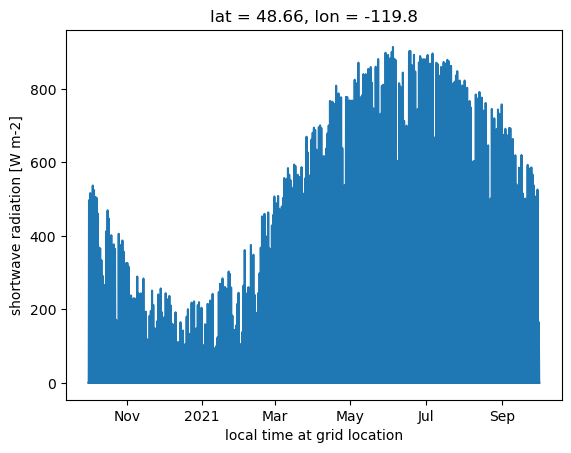

In [18]:
output['shortwave'].plot()